# NLM3 TASK 2: SENTIMENT ANALYSIS USING NEURAL NETWORKS

Rancel Hernandez

Feb 20, 2025

### Introduction  
Sentiment analysis allows businesses to classify their customers' feedback as positive or negative to help them assess their services and products.
In this analysis, the UCI Sentiment Labeled Sentences Data Set is used, which contains text data reviews from three different domains: Amazon, Yelp, and IMDb.

Research Question:
Which neural network architecture, sequential or functional, more accurately and confidently predicts sentiment in review data to help organizations better understand user sentiment?

Goals:
- Compare two neural network architectures, functional and sequential, of similar complexity for sentiment prediction.
- Optimize a dual-branch functional model with branches designed to capture opposing information.
- Create a comparable basic sequential model.
- Train both models on the same combined dataset: Amazon, IMDb, and Yelp reviews.
- Evaluate and compare performance metrics between the two optimal models.
- Gain insights into how model architecture influences sentiment classification performance.


This analysis will provide insights into whether specialized neural network architectures can improve sentiment prediction performance and generalize across various review domains.


## Imports

In [1]:
# load text data into DataFrames for data manipulation
import pandas as pd

# for relu inverse function
import tensorflow as tf

# for numpy arrays and to calculate statistical properties
import numpy as np

# use the en_core_web_md model from spaCy to tokenize sentences into word vectors 
import spacy  

# pattern matching
import re 

# pad the sequences that are lower than the input threshold to ensure a uniform input size
from tensorflow.keras.preprocessing.sequence import pad_sequences

# layers for building and structuring neural networks
from tensorflow.keras.layers import Dense, Input, Concatenate, Flatten, Dropout, Bidirectional, LSTM

# define the Sequential and Functional models
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

# for adding regularization to reduce overfitting
from tensorflow.keras.regularizers import l2

# callback to stop the training if no improvement
from tensorflow.keras.callbacks import EarlyStopping

# split the data into training, test, and validation sets
from sklearn.model_selection import train_test_split

# scale the word embeddings
from sklearn.preprocessing import StandardScaler 

# visualize and compare the distribution of the predictions
# and confusion matrix of the predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# load the optimal training history saved on a json file
import json

2025-03-09 20:41:17.932397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# hide the outputs
# install spaCy if not already installed
!pip install spacy > /dev/null 2>&1

# download en_core_web_md model
!python -m spaCy download en_core_web_md > /dev/null 2>&1

## Load and Eplore the Data
- Load the text files into their corresponding DataFrame.
- Explore the data by printing the shapes and the head of each DataFrame.
- Add a domain identifcation column to each DataFrame and combine them into one.
- Randomly sample `amazon_df` and `yelp_df` to proivide equal portions for each domain.
- Combine the label and domain column to stratify based on domain and lables in the train test split.

In [3]:
file_path = '/Users/rancelhernandez/Downloads/sentiment_labelled_sentences/amazon_cells_labelled.txt'

amazon_df = pd.read_csv(file_path, delimiter='\t', header=None, names=['sentence', 'label'])

file_path = '/Users/rancelhernandez/Downloads/sentiment_labelled_sentences/imdb_labelled.txt'

imdb_df = pd.read_csv(file_path, delimiter='\t', header=None, names=['sentence', 'label'])

file_path = '/Users/rancelhernandez/Downloads/sentiment_labelled_sentences/yelp_labelled.txt'

yelp_df = pd.read_csv(file_path, delimiter='\t', header=None, names=['sentence', 'label'])

In [4]:
amazon_df.shape

(1000, 2)

In [5]:
imdb_df.shape

(748, 2)

In [6]:
yelp_df.shape

(1000, 2)

In [7]:
amazon_df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [8]:
imdb_df.head()

,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [9]:
yelp_df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [10]:
# the imdb_df had 748 observations, while the other two had 1000.
# Therefore, amazon_df and yelp_df will be shortened to the same length
# with random sampling to ensure there are equal proportions for all 
# the domains.
amazon_df = amazon_df.sample(n=748, random_state=42)
yelp_df = yelp_df.sample(n=748, random_state=42)

# print the distribution of the labels
print("Amazon:", amazon_df.label.value_counts())
print("IMDb:", imdb_df.label.value_counts())
print("Yelp:", yelp_df.label.value_counts())

Amazon: label
1    385
0    363
Name: count, dtype: int64
IMDb: label
1    386
0    362
Name: count, dtype: int64
Yelp: label
0    382
1    366
Name: count, dtype: int64


In [11]:
# add the domain identification column
amazon_df["domain"] = "amazon"
imdb_df["domain"] = "imdb"
yelp_df["domain"] = "yelp"

# combine all the DataFrames into one
combined_df = pd.concat([amazon_df, yelp_df, imdb_df], ignore_index=True)

# combine domain and label into one column for stratification in train test split
combined_df['stratify_group'] = combined_df['domain'] + "_" + combined_df['label'].astype(str)

## Prepare the Data for the Analysis
- Identify and remove unusual characters.
- Transform sentences into sequences of word embeddings.
- Visualize the distribution of the sequence lengths using histograms.  
- Calculate and print the statistcal properties of the sequence lengths.
- Select the optimal max word embedding length.
- Pad and truncate the sequences to ensure unifrom inputs for the model.
- Visualize the distribution of the word vector values, excluding padded vectors.
- Standardize the word vectors.
- Split the data into the training, validation, and test sets

In [12]:
# compile the pattern for english chars
non_english_pattern = re.compile(r"[^a-z0-9\s]") 

# declare the set of punctuation not really considerd english chars
punctuation = ('~', '@', '?', ')', '<', '"', '+', ';', '.', '|', 
               '\\', "'", '(', '*', '!', '=', '>', '}', '/', '{', 
               '#', '_', '&', '$', '%', '`', '[', ':', ',', '^', '-', ']')

In [13]:
# B2 Tokenization Cell 13

# store all the sentences in a list
texts = combined_df["sentence"].to_list()

# load the spaCy model used to generate the word vectors
nlp = spacy.load('en_core_web_md')

# for words not in the spaCy model vocab, they will be padded with zeros
oov_vector = np.zeros((300,))  

# keep track of the proportion of words in and out of the vocab
in_vocab_count = 0
out_of_vocab_count = 0

# will contain all the sequences of word vectors
vectorized_sequences = []

# count all chars that are not english or punctuation
non_english_count = 0

# the list of unique unusual chars
unknown_chars = []

# will store the list of unique words in the dataset
vocab = []

# for each sentence, create a doc and vectorize each word and store
# the sequence of word vectors in vectorized_sequences
for sentence in texts:

    # using the pattern get all non english chars
    non_english = non_english_pattern.findall(sentence.lower())

    # for each char, check if its punctuation
    for char in non_english:

        # if it is not punctuation, then it is an unusual char
        if (char not in punctuation):

            # increment the total unusual chars 
            non_english_count += len(non_english)

            # replce the char with empty string to remove it
            sentence = sentence.replace(char, '')

            # check if it is in the current unknown_chars to collect all unique unknown chars
            if (char not in unknown_chars):
                unknown_chars.append(char)
    
    # create a document object from the sentence
    # to create a token object for each word
    doc = nlp(sentence)
    
    # create an 2D-array with (number of words in a sentence, 300)
    # 300 is the dimensionality of the GloVe word embeddings
    token_vectors = np.zeros((len(doc), 300))

    # iterate through all the words in the sentence
    for index, token in enumerate(doc):

        # check if the current word is in the vocab, if not add it
        if token.text not in vocab:
            vocab.append(token.text)
        
        # check if it has an existing embedding in the spaCy Model
        if token.has_vector:
            
            # increment the count of words in the vocab
            in_vocab_count += 1

            # add the current word vector at the correct index
            token_vectors[index] = token.vector
        else:
            # the word is out of the model's vocb

            # increment the count of words not in the vocab
            out_of_vocab_count += 1

            # pad the current index with a empty array
            token_vectors[index] = oov_vector

    # add the sequnce of word vectors to vectorized_sequences
    # a list of 2D numpy arrays, with each representing a sentence.
    vectorized_sequences.append(token_vectors)

In [14]:
print("Unusual Chars:", unknown_chars)
print("Count of unusual chars:", non_english_count)

Unusual Chars: ['ê', 'é', '\x96', 'å', '\x97']
Count of unusual chars: 349


In [15]:
print("Count of words with embeddings (in vocab)", in_vocab_count)
print("Count of words without embeddings (not in vocab):", out_of_vocab_count)
print("Count of unique words in the dataset:", len(vocab))

Count of words with embeddings (in vocab) 35557
Count of words without embeddings (not in vocab): 1431
Count of unique words in the dataset: 5472


In [16]:
# calculate sequence lengths
sequence_lengths = [len(seq) for seq in vectorized_sequences]

# calculate the statistical properties of the sequence lengths
print("Max length:", np.max(sequence_lengths))
print("Average length:", np.mean(sequence_lengths))
print("STD:", np.std(sequence_lengths))
print("95th percentile length:", np.percentile(sequence_lengths, 95))

Max length: 1842
Average length: 16.48306595365419
STD: 52.025593405645594
95th percentile length: 31.0


In [17]:
# check for outliers
long_sequences = [l for l in sequence_lengths if l > 100]

print("Number of sequences > 100 words:", len(long_sequences))
print("Longest sequence length:", max(sequence_lengths))
print("Shortest Longest sequence length:", min(long_sequences))

Number of sequences > 100 words: 5
Longest sequence length: 1842
Shortest Longest sequence length: 262


In [18]:
# truncate the sequences over a standard deviation of the sequence lengths (avg ~ 16 + 52)
vectorized_sequences = [seq[:68] for seq in vectorized_sequences]

# recalculate the sequence lengths
sequence_lengths = [len(seq) for seq in vectorized_sequences]

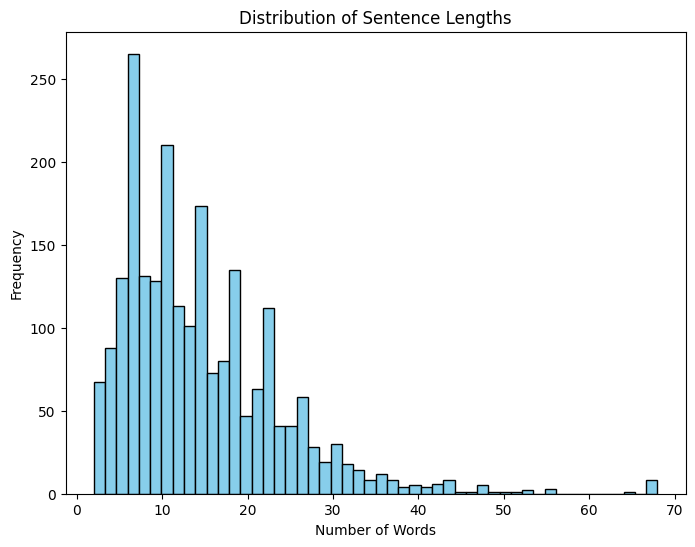

In [19]:
# plot distribution of the sequence lengths
plt.figure(figsize=(8, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [20]:
# recalculate the statistical properties of the sequence lengths
print("Max length:", np.max(sequence_lengths))
print("Average length:", np.mean(sequence_lengths))
print("STD:", np.std(sequence_lengths))
print("95th percentile length:", np.percentile(sequence_lengths, 95))

Max length: 68
Average length: 14.527629233511586
STD: 9.343258195196384
95th percentile length: 31.0


In [21]:
# choose maximum sequence length
max_length = 31  

# pad the sequences
padded_vectorized_sequences = pad_sequences(
    vectorized_sequences, 
    maxlen=max_length, 
    padding='post', 
    dtype='float32'
)

#print("padded_vectorized_sequences shape:", padded_vectorized_sequences.shape)

# print an example before and post padding
print("Pre-padded vector[2] example:", len(vectorized_sequences[2]))
print("Same padded vector[2] example:", len(padded_vectorized_sequences[2]))

Pre-padded vector[2] example: 7
Same padded vector[2] example: 31


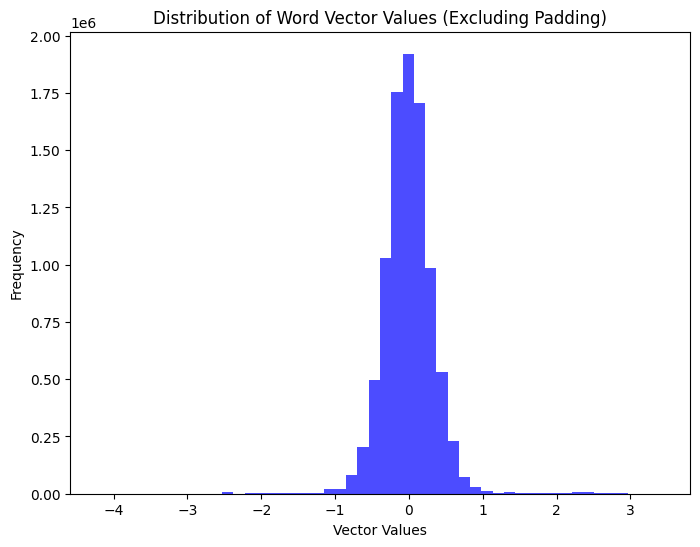

In [22]:
# exclude zero vectors (padding)

# flatten the vectors (2244, 31, 300) > (69564, 300)
flattened_vectors = padded_vectorized_sequences.reshape(-1, padded_vectorized_sequences.shape[-1])

# create a mask to filter out padded vectors 
# rows where all values sum to 0
mask = np.sum(flattened_vectors, axis=1) != 0

# apply the mask to retian non-padded vectors
non_zero_vectors = flattened_vectors[mask]

# plot distribution of non_zero_vectors
plt.figure(figsize=(8, 6))
plt.hist(non_zero_vectors.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Word Vector Values (Excluding Padding)")
plt.xlabel("Vector Values")
plt.ylabel("Frequency")
plt.show()

In [23]:
# calculate the statistical properties of the non_zero_vectors
mean_value = np.mean(non_zero_vectors)
std_value = np.std(non_zero_vectors)
print(f"Mean Value: {mean_value}, Standard Deviation: {std_value}")

Mean Value: -0.009188037365674973, Standard Deviation: 0.35151249170303345


In [24]:
# create the labels and stratification group
labels = combined_df['label']

# stratify_group WAS GONNA BE USED TO COMPARE GENERALIZATION OF DOMAINS BETWEEN MODELS
# stratifying by both labels and domain ensures equal distributions between the sources and possible outcomes
stratify_group = combined_df['stratify_group']

# split the data in 70% training set and 30% temp set
X_train, X_temp, y_train, y_temp, strat_train, strat_temp = train_test_split(
    padded_vectorized_sequences, 
    labels,
    stratify_group,
    test_size=0.3, 
    stratify=stratify_group,
    random_state=42
)

# use the 30% temp set to further split the into the 15% test and validations sets
X_test, X_val, y_test, y_val, strat_test, strat_val = train_test_split(
    X_temp,
    y_temp,
    strat_temp,
    test_size=0.5,
    stratify=strat_temp,
    random_state=42
)

In [25]:
# flatten X_train from 3D arr > 2D arr
X_train_flattened = X_train.reshape(-1, X_train.shape[2])

# scale the data
scaler = StandardScaler()

# fit and transform the train set
X_train_scaled_flattened = scaler.fit_transform(X_train_flattened)

# reshape it back to the original shape 
X_train_scaled = X_train_scaled_flattened.reshape(X_train.shape)

# apply same process to X_test and X_val
X_test_flattened = X_test.reshape(-1, X_train.shape[2])
X_test_scaled_flattened = scaler.transform(X_test_flattened)
X_test_scaled = X_test_scaled_flattened.reshape(X_test.shape)

X_val_flattened = X_val.reshape(-1, X_train.shape[2])
X_val_scaled_flattened = scaler.transform(X_val_flattened)
X_val_scaled = X_val_scaled_flattened.reshape(X_val.shape)

## Build the Models
- Define the inverse ReLu function.
- Create the Functional and Sequential models.
- Train both models.

In [26]:
# define a custom activation function
# will be the inverse relu so..
# x if x <= 0
# 0 if x > 
def inverse_relu(x):
    return tf.where(x <= 0, x, 0)


# set for more consistent training
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

In [27]:
# create the input layer for the model
input_layer = Input(shape=(X_train_scaled.shape[1], X_train.shape[2]))

# add a bidirectional LSTM before flattening to capture patterns in forward and backward directions
lstm_layer = Bidirectional(LSTM(30, return_sequences=True, dropout=0.4,
                                recurrent_dropout=0.4))(input_layer)

# flatten the LSTM output to prepare for dense layers
flattened = Flatten()(lstm_layer)

# branch 1: 
m1_layer1 = Dense(12, activation='relu', kernel_regularizer=l2(0.05))(flattened)
m1_layer1 = Dropout(0.4)(m1_layer1)

m1_layer2 = Dense(8, activation='tanh', kernel_regularizer=l2(0.05))(m1_layer1)
m1_layer2 = Dropout(0.3)(m1_layer2)

m1_layer3 = Dense(8, activation='relu', kernel_regularizer=l2(0.05))(m1_layer2)
m1_layer3 = Dropout(0.3)(m1_layer3)

# branch 2: 
m2_layer1 = Dense(12, activation=inverse_relu, kernel_regularizer=l2(0.05))(flattened)
m2_layer1 = Dropout(0.4)(m2_layer1)

m2_layer2 = Dense(8, activation='tanh', kernel_regularizer=l2(0.05))(m2_layer1)
m2_layer2 = Dropout(0.3)(m2_layer2)

m2_layer3 = Dense(8, activation=inverse_relu, kernel_regularizer=l2(0.05))(m2_layer2)
m2_layer3 = Dropout(0.3)(m2_layer3)

# combine the branches
combined = Concatenate()([m1_layer3, m2_layer3])

# add a shared layer before the output
shared_layer1 = Dense(10, activation='tanh', kernel_regularizer=l2(0.05))(combined)
shared_layer1 = Dropout(0.3)(shared_layer1)

# output layer with sigmoid activation for binary classification
output_layer = Dense(1, activation='sigmoid')(shared_layer1)

# define the functional model 
functional_model = Model(inputs=input_layer, outputs=output_layer)

# compile the model using adam optimizer, binary cross-entropy loss, and accuracy, recall, and precision as metrics
functional_model.compile(optimizer='adam', 
                         loss='binary_crossentropy', 
                         metrics=['accuracy'])

# stop after 5 epochs with no progress
early_stopping_monitor = EarlyStopping(patience=5)

In [28]:
# fit the model up to 30 epochs
history_functional = functional_model.fit(X_train_scaled, 
                                          y_train, 
                                          epochs=30, 
                                          validation_split=0.3, 
                                          callbacks=[early_stopping_monitor]) 

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5214 - loss: 4.9105 - val_accuracy: 0.5393 - val_loss: 3.4588
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5233 - loss: 3.1916 - val_accuracy: 0.5372 - val_loss: 2.5754
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5434 - loss: 2.4483 - val_accuracy: 0.5966 - val_loss: 2.1398
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5591 - loss: 2.0691 - val_accuracy: 0.5945 - val_loss: 1.8603
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5741 - loss: 1.8068 - val_accuracy: 0.6178 - val_loss: 1.6465
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5889 - loss: 1.6018 - val_accuracy: 0.6327 - val_loss: 1.4682
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5894 - loss: 1.4341 - val_accuracy: 0.6285 - val_loss: 1.3240
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6038 - loss: 1.2943 - val_accuracy: 0.6391 - v

In [29]:
# initialize the sequential model
sequential_model = Sequential()

# add the input layer
sequential_model.add(Input(shape=(X_train_scaled.shape[1], X_train.shape[2])))

# add the bidirectional LSTM before flattening to capture patterns in both forward and backward directions
sequential_model.add(Bidirectional(LSTM(30, return_sequences=True,  dropout=0.4, recurrent_dropout=0.4)))

# flatten the LSTM output to prepare for dense layers
sequential_model.add(Flatten())

# the first layer is equivalent to the the first layer of the functional model (12 nodes each distinct layer)
sequential_model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.05)))
sequential_model.add(Dropout(0.4))

# the second layer is equivalent to the the second layer of the functional model (8 nodes each distinct layer)
sequential_model.add(Dense(16, activation='tanh', kernel_regularizer=l2(0.05)))
sequential_model.add(Dropout(0.3))

sequential_model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
sequential_model.add(Dropout(0.3))

# the first shared layer wiith 10 nodes
sequential_model.add(Dense(10, activation='tanh', kernel_regularizer=l2(0.05)))
sequential_model.add(Dropout(0.3))

# the output laye with sigmoid activation for binary classification
sequential_model.add(Dense(1, activation='sigmoid'))

# compile the model using adam optimizer, binary cross-entropy loss, and accuracy, recall, and precision as metrics
sequential_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

In [30]:
# fit the model up to 30 epochs
history_sequential = sequential_model.fit(X_train_scaled, 
                                          y_train, 
                                          epochs=30, 
                                          validation_split=0.3, 
                                          callbacks=[early_stopping_monitor]) 

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5034 - loss: 4.8706 - val_accuracy: 0.5308 - val_loss: 3.4211
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5098 - loss: 3.1296 - val_accuracy: 0.5541 - val_loss: 2.4216
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5426 - loss: 2.2773 - val_accuracy: 0.5074 - val_loss: 1.9260
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5248 - loss: 1.8445 - val_accuracy: 0.6391 - val_loss: 1.6155
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5895 - loss: 1.5564 - val_accuracy: 0.6136 - val_loss: 1.3941
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5809 - loss: 1.3502 - val_accuracy: 0.6306 - val_loss: 1.2242
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6036 - loss: 1.1904 - val_accuracy: 0.6285 - val_loss: 1.0943
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5776 - loss: 1.0739 - val_accuracy: 0.6285 - v

## Assess Both Current Models
- Print the performance metrics.

In [31]:
print("Functional Model:")
print("Final Training Loss:", round(history_functional.history['loss'][-1], 4))
print("Final Validation Loss:", round(history_functional.history['val_loss'][-1], 4))
print("Final Training Accuracy:", round(history_functional.history['accuracy'][-1], 4))
print("Final Validation Accuracy", round(history_functional.history['val_accuracy'][-1], 4))

print("\nSequential Model:")
print("Final Training Loss:", round(history_sequential.history['loss'][-1], 4))
print("Final Validation Loss:", round(history_sequential.history['val_loss'][-1], 4))
print("Final Training Accuracy:", round(history_sequential.history['accuracy'][-1], 4))
print("Final Validation Accuracy", round(history_sequential.history['val_accuracy'][-1], 4))

Functional Model:
Final Training Loss: 0.6297
Final Validation Loss: 0.714
Final Training Accuracy: 0.7825
Final Validation Accuracy 0.6985

Sequential Model:
Final Training Loss: 0.6934
Final Validation Loss: 0.6931
Final Training Accuracy: 0.5068
Final Validation Accuracy 0.5138


## Assess the Optimal Models

Note: The optimal models are those saved from the training with peak performance. The current models shown above are just the most recently initialized versions, which may or may not converge to the same level of performance. The optimal models were saved due to the inconsistent converging during training.

- Visualize the optimal models' loss and accuracy.
- Display the current and optimal models' output summary.
- Load all the saved models.
    - Optimal Functional
    - Optimal Sequential
- Evaluate the models
- Print and comapare their performance.

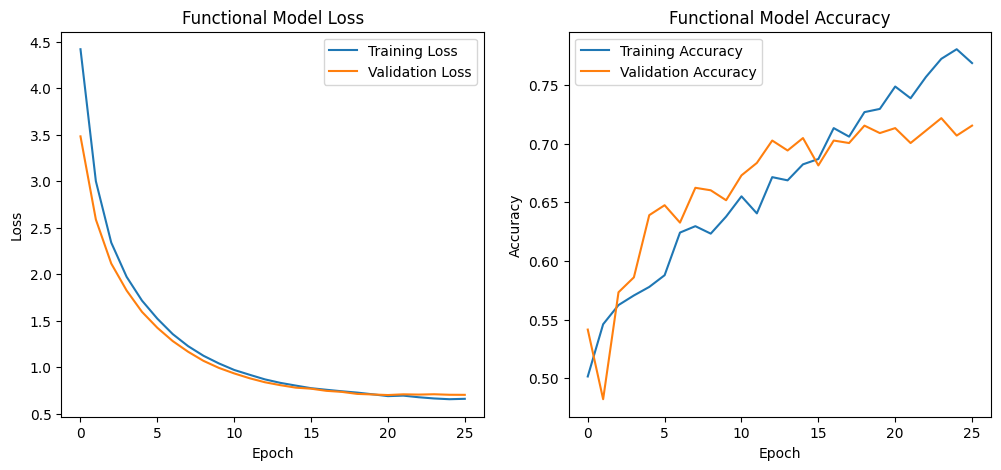

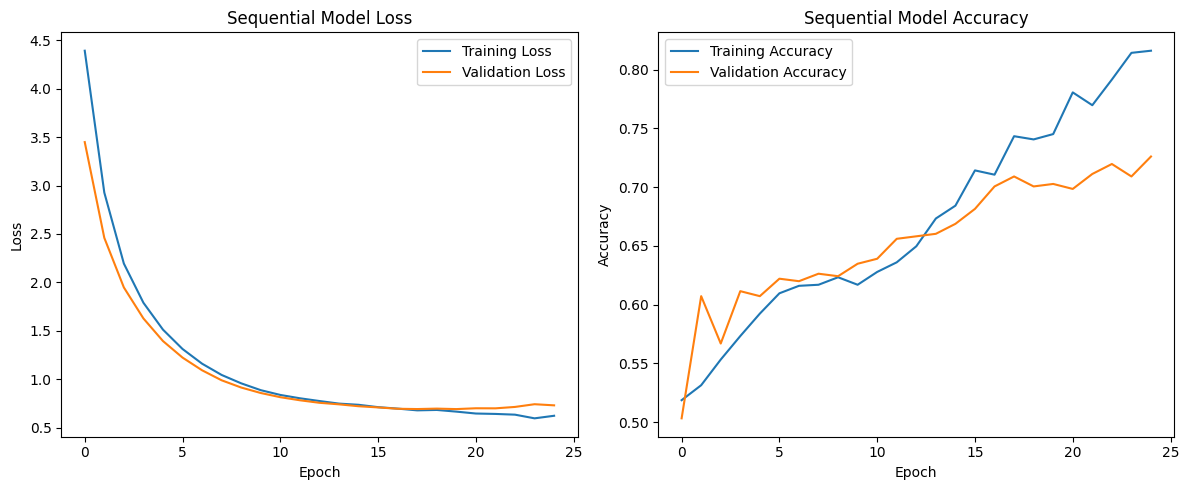

In [32]:
file_path = "/Users/rancelhernandez/Downloads/D213_Task2_Files/model_history_1.json"

# load the optimal functional model training history from the json file
with open(file_path, 'r') as f:
    history_functional = json.load(f)

# create figure and axis for the plot
plt.figure(figsize=(12, 5))

# plot training and validation loss
plt.subplot(1, 2, 1)  
plt.plot(history_functional['loss'], label='Training Loss')
plt.plot(history_functional['val_loss'], label='Validation Loss')
plt.title('Functional Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot training and validation accuracy 
plt.subplot(1, 2, 2)  
plt.plot(history_functional['accuracy'], label='Training Accuracy')
plt.plot(history_functional['val_accuracy'], label='Validation Accuracy')
plt.title('Functional Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

file_path = "/Users/rancelhernandez/Downloads/D213_Task2_Files/history_sequential_1.json"

# load the optimal sequential model training history from the json file
with open(file_path, 'r') as f:
    history_sequential = json.load(f)

# create figure and axis for the plot
plt.figure(figsize=(12, 5))

# plot training and validation loss
plt.subplot(1, 2, 1)  
plt.plot(history_sequential['loss'], label='Training Loss')
plt.plot(history_sequential['val_loss'], label='Validation Loss')
plt.title('Sequential Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot training and validation accuracy 
plt.subplot(1, 2, 2)  
plt.plot(history_sequential['accuracy'], label='Training Accuracy')
plt.plot(history_sequential['val_accuracy'], label='Validation Accuracy')
plt.title('Sequential Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# load the saved optimal functional and sequential models to confirm their architecure
file_path = "/Users/rancelhernandez/Downloads/D213_Task2_Files/functional_model_1.keras"

optimal_functional_model = tf.keras.models.load_model(file_path,
                                     custom_objects={'inverse_relu': inverse_relu})

file_path = "/Users/rancelhernandez/Downloads/D213_Task2_Files/sequential_model_0.keras"

optimal_sequential_model = tf.keras.models.load_model(file_path)

# all current and loaded functional models have the same structure
# current functional model
print(functional_model.summary())

# optimal functional model
print(optimal_functional_model.summary())

# current sequential model
print(sequential_model.summary())

# optimal sequential model
print(optimal_sequential_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 31, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 31, 60)    │     79,440 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1860)      │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12)        │     22,332 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12)        │     22,332 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 12)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        104 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8)         │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8)         │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │         72 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │         72 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8)         │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8)         │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        170 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 10)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         11 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 373,913 (1.43 MB)

 Trainable params: 124,637 (486.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 249,276 (973.74 KB)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 31, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 31, 60)    │     79,440 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1860)      │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12)        │     22,332 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12)        │     22,332 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 12)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        104 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8)         │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8)         │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │         72 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │         72 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8)         │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8)         │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        170 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 10)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         11 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 373,913 (1.43 MB)

 Trainable params: 124,637 (486.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 249,276 (973.74 KB)

None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 31, 60)         │        79,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1860)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │        44,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,873 (1.43 MB)

 Trainable params: 124,957 (488.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 249,916 (976.24 KB)

None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 31, 60)         │        79,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1860)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │        44,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,873 (1.43 MB)

 Trainable params: 124,957 (488.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 249,916 (976.24 KB)

None


In [34]:
# NOTE: the '_' is unpacking recall and precision which is no longer considered

# Optimal Functional Model 5
opf_test_loss, opf_test_acc, _, _ = optimal_functional_model.evaluate(X_test_scaled, y_test)     
opf_train_loss, opf_train_acc, _, _ = optimal_functional_model.evaluate(X_train_scaled, y_train)
opf_val_loss, opf_val_acc, _, _ = optimal_functional_model.evaluate(X_val_scaled, y_val)

# Optimal Sequential Model 4
sm_test_loss, sm_test_acc, _, _ = optimal_sequential_model.evaluate(X_test_scaled, y_test)     
sm_train_loss, sm_train_acc, _, _ = optimal_sequential_model.evaluate(X_train_scaled, y_train)
sm_val_loss, sm_val_acc, _, _ = optimal_sequential_model.evaluate(X_val_scaled, y_val)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7239 - loss: 0.6805 - precision: 0.7149 - recall: 0.7330
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8437 - loss: 0.5811 - precision: 0.8428 - recall: 0.8460
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6871 - loss: 0.7142 - precision: 0.6899 - recall: 0.7018
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6840 - loss: 1.0410 - precision: 0.6980 - recall: 0.6374
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9624 - loss: 0.3482 - precision: 0.9827 - recall: 0.9414
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6604 - loss: 1.1828 - precision: 0.6980 - recall: 0.5825


In [35]:
# print the performance metrics/error of all the models
print("\nOptimal Functional Model:")
print(f"Train Accuracy: {opf_train_acc * 100:.2f}%")
print(f"Test Accuracy: {opf_test_acc * 100:.2f}%")
print(f"Val. Accuracy: {opf_val_acc * 100:.2f}%")
print(f"Train Loss: {opf_train_loss:.4f}")
print(f"Test Loss: {opf_test_loss:.4f}")
print(f"Val. Loss: {opf_val_loss:.4f}")

print("\nOptimal Sequential Model:")
print(f"Train Accuracy: {sm_train_acc * 100:.2f}%")
print(f"Test Accuracy: {sm_test_acc * 100:.2f}%")
print(f"Val. Accuracy: {sm_val_acc * 100:.2f}%")
print(f"Train Loss: {sm_train_loss:.4f}")
print(f"Test Loss: {sm_test_loss:.4f}")
print(f"Val. Loss: {sm_val_loss:.4f}")


Optimal Functional Model:
Train Accuracy: 81.15%
Test Accuracy: 70.92%
Val. Accuracy: 70.92%
Train Loss: 0.6103
Test Loss: 0.6851
Val. Loss: 0.7001

Optimal Sequential Model:
Train Accuracy: 89.68%
Test Accuracy: 66.47%
Val. Accuracy: 67.06%
Train Loss: 0.5304
Test Loss: 1.0873
Val. Loss: 1.1428


## Results
- The reviews contained no emojis, but did have the following unknown characters: ['ê', 'é', '\x96', 'å', '\x97'].
- There were 349 unusual characters in the reviews.
- There were five outliers, with the longest having a max length of 1,842 words.
- There were 5,472 unique words from the reviews.
- From the reviews, 35,557 words were found in the SpaCy model's vocabulary, while 1,431 words were not found in the vocabulary.
- The chosen max word embedding length was 31 because that was the 95th percentile of the sequence lengths, meaning 95% of the sentences would fall within this threshold.
- The word vector values appeared to follow a normal distribution with a mean of approximately 0 and a standard deviation of approximately 0.35.
- The final structure of the functional model:
    - 1 Input Layer (31 x 300)
    - 2 Bidirectional LSTM Layer with 30 units (30 x 2 = 60 nodes total)
    - 3 Flatten Layer to convert sequential data to flat features
    - 4 Two Distinct Dense Layers, 12 nodes each (Activations: ReLu and Inverse ReLu)
    - 5 Dropout applied to each branch
    - 6 Two Distinct Dense Layers, 8 nodes each (Activations: Tanh)
    - 7 Dropout applied to each branch
    - 8 Two Distinct Dense Layers, 8 nodes each (Activations: ReLu and Inverse ReLu)
    - 9 Dropout applied to each branch
    - 10 Concatenation of both branches
    - 11 Shared Dense Layer with 10 nodes (Activation: Tanh)
    - 12 Dropout Layer
    - 13 Output Layer with 1 node (Activation: Sigmoid)
- The final structure of the sequential model:
    - 1 Bidirectional LSTM Layer with 30 units (30 x 2 = 60 nodes total)
    - 2 Flatten Layer to convert sequential data to flat features
    - 3 Dense Layer with 24 nodes (Activations: ReLu)
    - 4 Dropout Layer
    - 5 Dense Layer with 16 nodes (Activations: Tanh)
    - 6 Dropout Layer
    - 7 Dense Layer with 16 nodes (Activations: ReLu)
    - 8 Dropout Layer
    - 9 Dense Layer with 10 nodes (Activations: Tanh)
    - 10 Dropout Layer
    - 11 Output Layer with 1 node (Activations: Sigmoid)

## Reccomondations

- Reduce training duration from 30 to 15 epochs and decrease early stopping patience from 5 to 2 epochs to minimize overfitting.
- Further explore the functional model architecture due to its more reliable and confident predictions.
- Test whether both branches learned useful or redundant patterns by adding output nodes at the branch endpoints and investigating if the standard ReLU has higher true positive rates while inverse ReLU has higher true negative rates.
- Increase model complexity by adding more nodes, hidden layers, and alternative activation functions.
- Consider adding a third branch that incorporates both inverse functions or other activation functions.
- Test the model performance across different domains (Amazon, IMDb, Yelp) to identify potential domain-specific accuracy variations.
- Test the model on the different domains (Amazon, IMDb, Yelp) to identify if there is any bias.
- Obtain more training data to improve the overall performance.

In [36]:
# code to save the models and their history

# save the models 
#sequential_model.save('sequential_model_o.keras')
#functional_model.save('functional_model_o.keras')

In [37]:
# save the models' history in json format

#output_path = "/Users/rancelhernandez/Downloads/D213_Task2_Models/history_sequential_1.json"

#history_dict = history_sequential.history

#with open(output_path, 'w') as f:
    #json.dump(history_dict, f, indent=4)

#output_path = "/Users/rancelhernandez/Downloads/D213_Task2_Models/model_history_1.json"

#history_dict = history_functional.history

#with open(output_path, 'w') as f:
    #json.dump(history_dict, f, indent=4)

In [38]:
# save the prepared data

# save the arrays in compressed format
#np.savez_compressed('prepared_dataset.npz', 
#                    X_train=X_train_scaled,
#                    X_val=X_val_scaled, 
#                    X_test=X_test_scaled,
#                    y_train=y_train, 
#                    y_val=y_val, 
#                    y_test=y_test)